In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [167]:
scale_train = pd.read_csv("d_reg_tra.csv")
scale_train= scale_train.sort_values(by=['x'])
scale_validation = pd.read_csv("d_reg_val.csv")
scale_validation= scale_validation.sort_values(by=['x'])
merged=pd.concat([scale_train, scale_validation], axis=0, sort=False)
merged.reset_index(inplace=True,drop=True)
merged_X=merged.x.to_numpy()
merged_Y=merged.y.to_numpy()
merged_X=(merged_X - merged_X.mean())/np.var(merged_X)
merged_X_train=merged_X[:len(scale_train)]
merged_Y_train=merged_Y[:len(scale_train)]
merged_X_validation=merged_X[len(scale_train):]
merged_Y_validation=merged_Y[len(scale_train):]

# RBF

In [168]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

def kmeans(X, k):
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False

    while not converged:

        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        closestCluster = np.argmin(distances, axis=1)

        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)

        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()

    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
 
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

    return clusters, stds

class RBFNet(object):
    def __init__(self, k=5, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds

        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
    def fit(self, X, y):
        if self.inferStds:
            self.centers, self.stds = kmeans(X, self.k)
        else:
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        loss_np =[]
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b 
                loss = (y[i] - F).flatten() ** 2
                loss_np= np.concatenate((loss_np, loss), axis=0)
                error = -(y[i] - F).flatten()
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
        return float(loss_np.mean())
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b 
            y_pred.append(F)
        return np.array(y_pred)

# Rules and Exceptions

In [142]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

def kmeans(X, k):

    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False

    while not converged:

        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

        closestCluster = np.argmin(distances, axis=1)

        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)

        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()

    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:

            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])

    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

    return clusters, stds

class RBFNet(object):

    def __init__(self, k=5, lr=0.01, epochs=200, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds

        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
        self.b1=np.random.randn(1)

    def fit(self, X, y):
        if self.inferStds:
 
            self.centers, self.stds = kmeans(X, self.k)
        else:

            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        loss_np =[]
        H_w=np.random.randn(X.shape[0],self.epochs)
        H=np.random.randn(X.shape[0],self.epochs)

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):

                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b + np.dot((self.b1).T,X[i])

 

                loss = (y[i] - F).flatten() ** 2

                loss_np= np.concatenate((loss_np, loss), axis=0)
  
                error = -(y[i] - F).flatten()

                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
                self.b1=self.b1 - self.lr *X[i] * error
                

        return float(loss_np.mean())
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b + np.dot((self.b1).T,X[i])
            y_pred.append(F)
        return np.array(y_pred)  

## Training Datasının işlenilmesi ve modelin oluşumu

i 0.1
 k 2
  Learning Rate: 0.1 K: 2 Epoch: 10 Loss: 6.357282052498192
  Learning Rate: 0.1 K: 2 Epoch: 50 Loss: 5.7512892870825345
  Learning Rate: 0.1 K: 2 Epoch: 100 Loss: 5.743684814588649
  Learning Rate: 0.1 K: 2 Epoch: 500 Loss: 5.929874996979759
  Learning Rate: 0.1 K: 2 Epoch: 1000 Loss: 5.929874996979759
 k 3
  Learning Rate: 0.1 K: 3 Epoch: 10 Loss: 8.141259196939208
  Learning Rate: 0.1 K: 3 Epoch: 50 Loss: 9.04133213764188
  Learning Rate: 0.1 K: 3 Epoch: 100 Loss: 9.059047815216807
  Learning Rate: 0.1 K: 3 Epoch: 500 Loss: 9.05962740993361
  Learning Rate: 0.1 K: 3 Epoch: 1000 Loss: 8.095239237626702
 k 4
  Learning Rate: 0.1 K: 4 Epoch: 10 Loss: 6.941818965839223
  Learning Rate: 0.1 K: 4 Epoch: 50 Loss: 9.223077984905037
  Learning Rate: 0.1 K: 4 Epoch: 100 Loss: 6.186667744755431
  Learning Rate: 0.1 K: 4 Epoch: 500 Loss: 7.2650108583148505
  Learning Rate: 0.1 K: 4 Epoch: 1000 Loss: 6.3713817385324605
 k 5
  Learning Rate: 0.1 K: 5 Epoch: 10 Loss: 6.70855056307333
  

  Learning Rate: 0.0001 K: 7 Epoch: 100 Loss: 8.748176514743589
  Learning Rate: 0.0001 K: 7 Epoch: 500 Loss: 7.883530731689963
  Learning Rate: 0.0001 K: 7 Epoch: 1000 Loss: 7.392801756694372
 k 8
  Learning Rate: 0.0001 K: 8 Epoch: 10 Loss: 8.645147101059155
  Learning Rate: 0.0001 K: 8 Epoch: 50 Loss: 8.91497648267794
  Learning Rate: 0.0001 K: 8 Epoch: 100 Loss: 8.427937123277301
  Learning Rate: 0.0001 K: 8 Epoch: 500 Loss: 7.5534916936753405
  Learning Rate: 0.0001 K: 8 Epoch: 1000 Loss: 7.319251976823812
Loss: 7.742634155325007


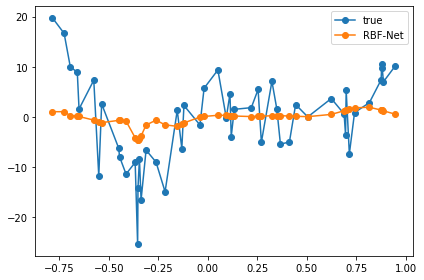

In [169]:
X = merged_X_train
y = merged_Y_train


lr_list=[0.1,0.01,0.001,0.0001]
epo_list=[10,50,100,500,1000]
k_list=[2,3,4,5,6,7,8]
found_lr=0
found_epo=0
found_k=0
min_found_loss=999
for i in lr_list:
  print("i",i)
  for k_ in k_list:
    print(" k",k_)
    for epo in epo_list:
      rbfnet = RBFNet(lr=i, k=k_,epochs=epo, inferStds=True)
      returned_min_loss=rbfnet.fit(X, y)
      y_pred = rbfnet.predict(X)
      loss=[]
      for index in range(len(X)):
          loss= np.concatenate((loss, (y[index]-y_pred[index])**2), axis=0)
      if(loss.mean()>=0):
          min_found_loss= loss.mean()
          found_lr=i
          found_epo=epo
          found_k=k_
          print("  Learning Rate:",found_lr,"K:",found_k,"Epoch:",epo,"Loss:",(min_found_loss)**0.5)
        

rbfnet = RBFNet(lr=found_lr, k=found_k,epochs=found_epo, inferStds=True)
returned_min_loss=rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)



loss=[]
for index in range(len(X)):
    MSE=(y[index]-y_pred[index])**2
    loss= np.concatenate((loss,MSE), axis=0)

print("Loss:",loss.mean()**0.5)

plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()




## Validation 

Loss: 8.065637574243606


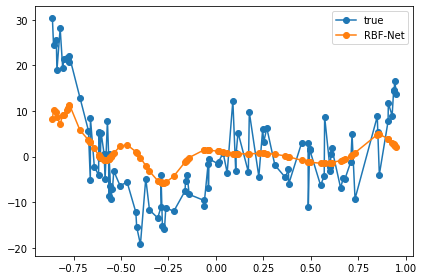

In [144]:
val_X = merged_X_validation
val_y = merged_Y_validation

returned_min_loss=rbfnet.fit(val_X, val_y)
y_val_pred = rbfnet.predict(val_X)

validation_loss=[]
for index in range(len(val_X)):
    validation_loss= np.concatenate((validation_loss,(val_y[index]-y_val_pred[index])**2), axis=0)

print("Loss:",validation_loss.mean()**0.5)
        
plt.plot(val_X, val_y, '-o', label='true')
plt.plot(val_X, y_val_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()


**Best Fit**

Loss: 5.545350134225106


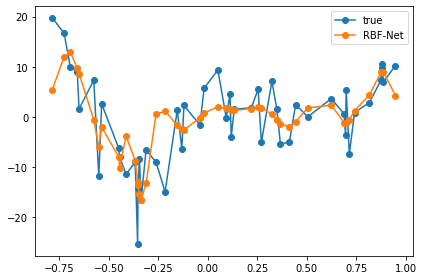

In [170]:
rbfnet = RBFNet(lr=0.01, k=9,epochs=1000, inferStds=True)
returned_min_loss=rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)


train_loss=[]
for index in range(len(X)):
    train_loss= np.concatenate((train_loss, (y[index]-y_pred[index])**2), axis=0)


print("Loss:",train_loss.mean()**0.5)


plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()


Loss: 5.32569944211945


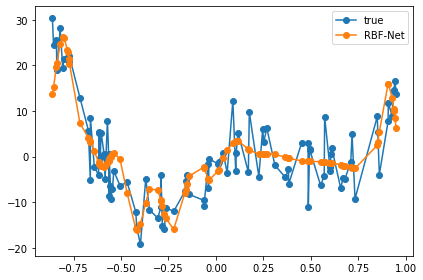

In [146]:
returned_min_loss=rbfnet.fit(val_X, val_y)
y_val_pred = rbfnet.predict(val_X)
    



validation_loss=[]
for index in range(len(val_X)):
    validation_loss= np.concatenate((validation_loss, (val_y[index]-y_val_pred[index])**2), axis=0)


print("Loss:",validation_loss.mean()**0.5)

        
plt.plot(val_X, val_y, '-o', label='true')
plt.plot(val_X, y_val_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

**Underfit**

Loss: 15.501182917157685


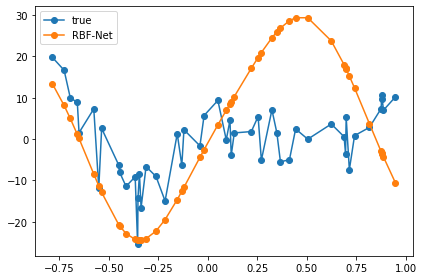

In [147]:
rbfnet = RBFNet(lr=1, k=2,epochs=10, inferStds=True)
returned_min_loss=rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)

loss=[]
for index in range(len(X)):
    loss= np.concatenate((loss, (y[index]-y_pred[index])**2), axis=0)

print("Loss:",loss.mean()**0.5)


plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

Loss: 273.966055119986


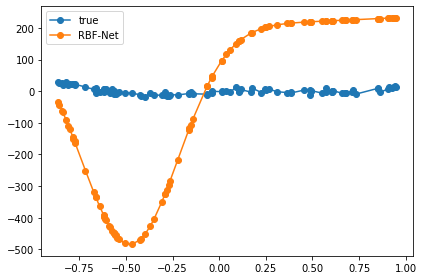

In [148]:
returned_min_loss=rbfnet.fit(val_X, val_y)
y_val_pred = rbfnet.predict(val_X)
    

validation_loss=[]
for index in range(len(val_X)):
    validation_loss= np.concatenate((validation_loss, (val_y[index]-y_val_pred[index])**2), axis=0)


print("Loss:",validation_loss.mean()**0.5)

        
plt.plot(val_X, val_y, '-o', label='true')
plt.plot(val_X, y_val_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

# Overfit

Loss: 5.173371488655734


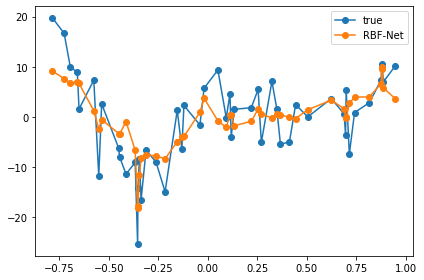

In [149]:
rbfnet = RBFNet(lr=0.001, k=25,epochs=1000, inferStds=True)
returned_min_loss=rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)



loss=[]
for index in range(len(X)):
    loss= np.concatenate((loss, (y[index]-y_pred[index])**2), axis=0)


print("Loss:",loss.mean()**0.5)





plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

Loss: 4.9509273003527605


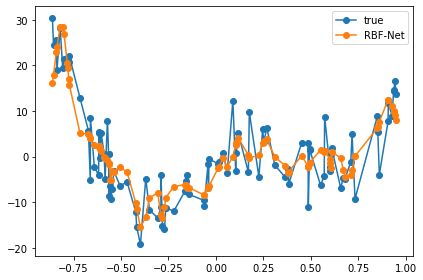

In [150]:
returned_min_loss=rbfnet.fit(val_X, val_y)
y_val_pred = rbfnet.predict(val_X)
    

validation_loss=[]
for index in range(len(val_X)):
    validation_loss= np.concatenate((validation_loss, (val_y[index]-y_val_pred[index])**2), axis=0)


print("Loss:",validation_loss.mean()**0.5)

        
plt.plot(val_X, val_y, '-o', label='true')
plt.plot(val_X, y_val_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

In [151]:
X = merged_X_train
y = merged_Y_trainweights_last = pd.DataFrame(w.T,
                   columns=['weights'])

In [152]:
centers, _ = kmeans(X,9)
_,stds=kmeans(X,9)
print(centers)
print(stds)

[ 0.1212028  -0.37539779  0.88110581  0.34565587 -0.64747107  0.56430995
 -0.09303348  0.70788495 -0.23883602]
[0.0824307  0.06698983 0.05568287 0.51172481 0.03086316 0.06137924
 0.07554151 0.01311956 0.02715695]


In [153]:
h_x=[]
for i in range(len(X)):
     a=np.array([rbf(X[i], c, s) for c, s, in zip(centers,stds)])
     
     h_x.append(a)
    

In [154]:
hx= pd.DataFrame(h_x,dtype=int)


In [155]:
hx.columns=['1.cluster','2.cluster','3.cluster','4.cluster','5.cluster','6.cluster','7.cluster','8.cluster','9.cluster']

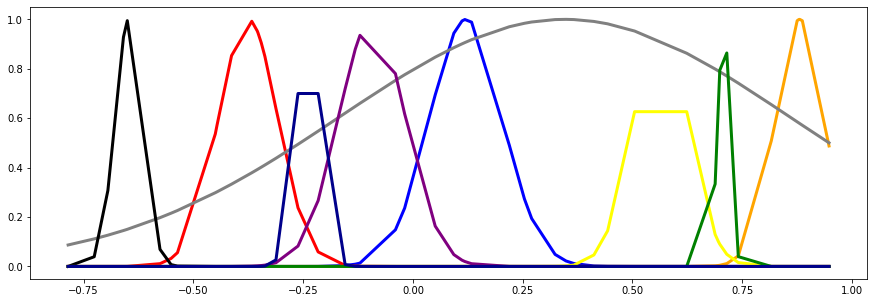

In [156]:
color_list=['blue','red','orange','grey','black','yellow','purple','green','darkblue','darkgreen']

plt.figure(num = 3, figsize=(15, 5))
for i in range(9):
    plt.plot(X, hx.iloc[:,i], color=color_list[i],linewidth=3.0)
plt.show()

In [171]:
k=9
w = np.random.randn(k)
b = np.random.randn(1)
loss_np =[]
centers, stds = kmeans(X, k)
epochs=20
#hxn=hx.to_numpy()
multiplied_list=[]
lr=0.1
# training
for epoch in range(epochs):
  for i in range(X.shape[0]):
      a = np.array([rbf(X[i], c, s) for c, s, in zip(centers, stds)])
      F = a.T.dot(w) + b 

      error = -(y[i] - F).flatten()

      w = w - lr * a * error
      b = b - lr * error

      



In [172]:
weights_last = pd.DataFrame(w.T,
                   columns=['weights'])


In [173]:
weights_last2=weights_last.to_numpy();

In [174]:
weights_hx=[]
for i in range(9):
  a=(hx.iloc[:,i]*weights_last2[i])
  weights_hx.append(a)

In [175]:
weights_hx=pd.DataFrame(weights_hx)

In [176]:
weights_hx.T

,1.cluster,2.cluster,3.cluster,4.cluster,5.cluster,6.cluster,7.cluster,8.cluster,9.cluster
0,-9.571920e-26,-5.849784e-09,-2.362131e-195,-0.144298,3.781279e-04,1.833626e-105,-7.157680e-19,-0.000000e+00,2.435018e-89
1,-2.055182e-22,-9.017314e-07,-1.005164e-181,-0.185287,3.247043e-01,2.037207e-96,-7.125593e-16,-0.000000e+00,3.022894e-71
2,-9.259035e-21,-9.200828e-06,-8.664401e-175,-0.210057,2.539101e+00,7.599787e-92,-2.063799e-14,-0.000000e+00,1.319758e-62
3,-5.993343e-19,-1.000634e-04,-4.837154e-167,-0.241293,7.669371e+00,9.125853e-87,-7.806699e-13,-0.000000e+00,1.912138e-53
4,-1.627518e-18,-1.725505e-04,-3.682704e-165,-0.249492,8.219591e+00,1.546880e-85,-1.847077e-12,-0.000000e+00,2.658936e-51
5,-5.135242e-15,-8.980648e-03,-1.467135e-149,-0.327787,5.709558e-01,2.027432e-75,-1.650997e-09,-0.000000e+00,7.276548e-35
6,-6.492194e-14,-2.580382e-02,-1.822989e-144,-0.357729,6.210290e-02,3.803362e-72,-1.315919e-08,-0.000000e+00,4.739191e-30
7,-2.708604e-13,-4.460494e-02,-1.493211e-141,-0.375912,1.264882e-02,2.784318e-70,-4.167451e-08,-0.000000e+00,1.977287e-27
8,-6.534751e-10,-4.284729e-01,-5.668396e-125,-0.495352,1.116240e-08,8.798602e-60,-1.750880e-05,-0.000000e+00,1.586797e-14
9,-9.334057e-10,-4.590522e-01,-3.513407e-124,-0.501783,4.580718e-09,2.760880e-59,-2.281634e-05,-0.000000e+00,5.307692e-14


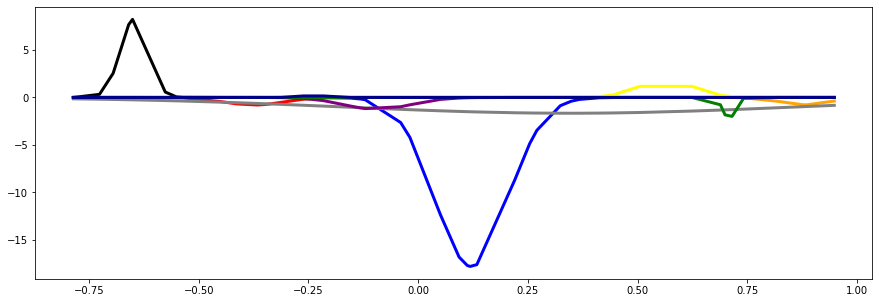

In [177]:
color_list=['blue','red','orange','grey','black','yellow','purple','green','darkblue','darkgreen']

plt.figure(num = 3, figsize=(15, 5))
for i in range(9):
    plt.plot(X, weights_hx.T.iloc[:,i], color=color_list[i],linewidth=3.0)
plt.show()